# Assignment 4b

In [1]:
import datasets
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
from transformers import DistilBertConfig, DistilBertForMaskedLM
import matplotlib.pyplot as plt

/Users/esmirmesic/opt/anaconda3/envs/cs144/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = datasets.load_dataset("damlab/uniprot")

Found cached dataset parquet (/Users/esmirmesic/.cache/huggingface/datasets/damlab___parquet/damlab--uniprot-28c00e1433a53e45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


In [3]:
device = torch.device("mps")

In [4]:
sequences = ds['train']['sequence'][:50000]

In [5]:
chars = sorted(list(set("".join(sequences))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y', 24: 'Z', 0: '.'}


# MLP Model From Class

In [6]:
context_length = 5

def make_dataset(sequences):
    X, y = [], []
    for seq in tqdm(sequences):
        context = [0] * context_length
        for ch in seq + '.':
            X.append(context)
            y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

In [7]:
trl = len(sequences)
Xtr, ytr = make_dataset(sequences[:int(0.9*trl)])
Xte, yte = make_dataset(sequences[int(.9*trl):int(.95*trl)])
Xdev, ydev = make_dataset(sequences[int(0.95*trl):])

100%|██████████| 5000/5000 [00:01<00:00, 3970.60it/s]


In [8]:
class Model1(nn.Module):
    def __init__(self, embd_dim):
        super().__init__()
        self.inp_dim = embd_dim * context_length
        self.C = nn.Embedding(len(itos), embd_dim)

        self.fc1 = nn.Linear(self.inp_dim, 4*self.inp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * self.inp_dim, self.inp_dim)
        self.fc3 = nn.Linear(self.inp_dim, len(itos))

    def forward(self, ix):
        x = self.C(ix).view(-1, self.inp_dim)

        h = self.fc1(x)
        h = self.gelu(h)
        h = self.fc2(h)
        h = self.gelu(h)
        h = self.fc3(h)
        return h
    

In [9]:
model = Model1(16)

In [10]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []

for step in range(10000):
    optimizer.zero_grad()
    ix = torch.randint(0, Xtr.shape[0], (32,))
    logits = model(Xtr[ix])
    loss = F.cross_entropy(logits, ytr[ix])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        print(f'{step=}, {loss=}')

step=0, loss=tensor(3.2265, grad_fn=<NllLossBackward0>)
step=1000, loss=tensor(2.9317, grad_fn=<NllLossBackward0>)
step=2000, loss=tensor(2.7578, grad_fn=<NllLossBackward0>)
step=3000, loss=tensor(2.7428, grad_fn=<NllLossBackward0>)
step=4000, loss=tensor(2.8401, grad_fn=<NllLossBackward0>)
step=5000, loss=tensor(2.7546, grad_fn=<NllLossBackward0>)
step=6000, loss=tensor(2.9629, grad_fn=<NllLossBackward0>)
step=7000, loss=tensor(2.8229, grad_fn=<NllLossBackward0>)
step=8000, loss=tensor(2.8588, grad_fn=<NllLossBackward0>)
step=9000, loss=tensor(2.8095, grad_fn=<NllLossBackward0>)


In [11]:
weight = next(model.named_parameters())[1].detach().numpy()
norm = np.linalg.norm(weight, axis=1)
norm_matrix = norm[:, None] * norm[None, :]
cosin_distance = (weight @ weight.T) / norm_matrix

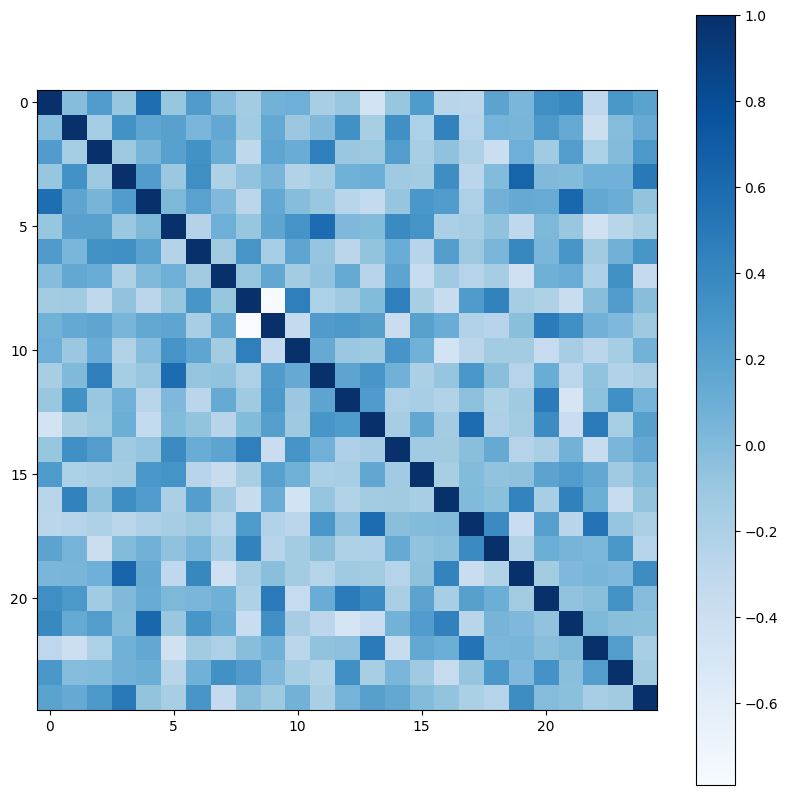

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(cosin_distance, cmap="Blues")
plt.colorbar()

In [13]:
pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

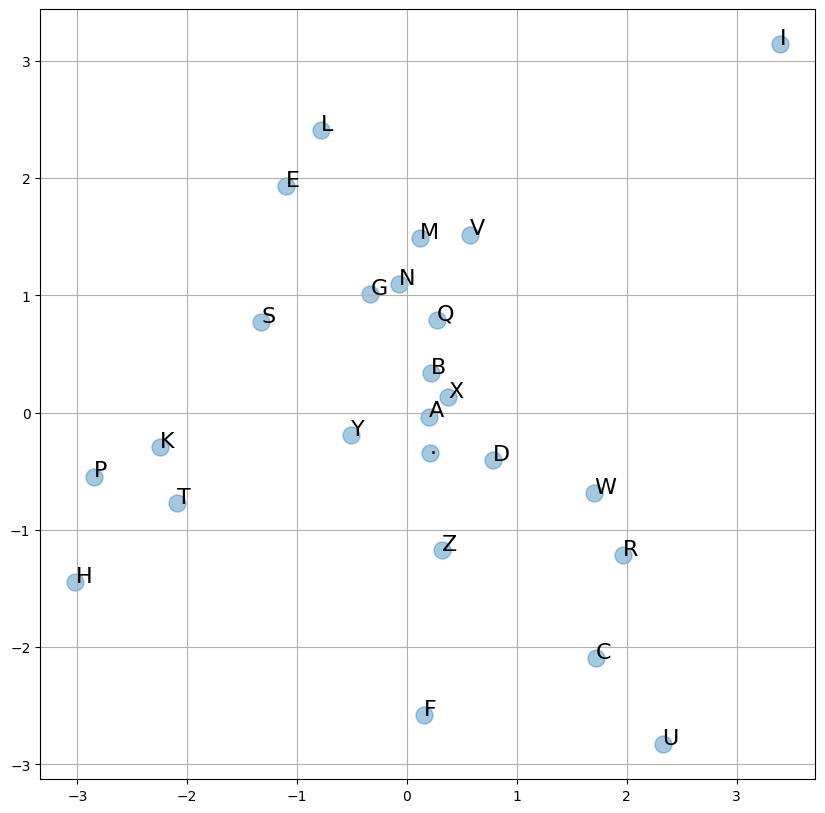

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(vis[:, 0], vis[:, 1], s=150, alpha=0.4)
plt.grid(True)
for ix, char in itos.items():
    plt.annotate(char, vis[ix], fontsize=16)

# BERT

This model is the DistilBert model from hugging face. It is a distilled version of the BERT model, which means it's a smaller version of the original BERT model that was reduced in size by 40% via knowledge distillation. It's great at understanding language just like the original BERT model, while being a lot faster. I figured its one of the more basic huggingface transformer models while still being interesting, so I chose it for this task. I know it's probably not made for this type of task but it seems ok. 

For this model, I preprocess the data in a similar way to how Rohit did in his MLP example in class, but adding more mask characters for the masking task (based on a probability distribution)

In [30]:
# context_length = 5

# def make_dataset(sequences):
#     X, y = [], []
#     for seq in tqdm(sequences):
#         context = [0] * context_length
#         for ch in seq + '.':
#             X.append(context[:context_length] + [stoi[ch]])
#             y.append(context[1:] + [stoi[ch], stoi['.']])
#             context = context[1:] + [stoi[ch]]
#     X, y = torch.tensor(X), torch.tensor(y)
#     return X, y

# Deprecated, doing next word prediction

In [31]:
context_length = 15
mask_probability = 0.15

def mask_sequence(sequence, stoi, mask_token_id):
    masked_sequence = []
    for ch in sequence:
        if np.random.rand() < mask_probability:
            masked_sequence.append(mask_token_id)
        else:
            masked_sequence.append(stoi[ch])
    return masked_sequence

def make_dataset(sequences, stoi, mask_token_id):
    X, y = [], []
    for seq in tqdm(sequences):
        context = [0] * context_length
        masked_seq = mask_sequence(seq, stoi, mask_token_id)
        masked_seq.append(mask_token_id)
        seq = seq + '.'
        for ch, masked_ch in zip(seq, masked_seq):
            X.append(context[:context_length] + [masked_ch])
            y.append(context[1:] + [stoi[ch], stoi['.']])
            context = context[1:] + [stoi[ch]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

In [8]:
config = DistilBertConfig(vocab_size = len(itos), embedding_size = 16, max_position_embeddings=context_length + 1, mask_token_id = stoi['.'])
trl = len(sequences)
Xtr, ytr = make_dataset(sequences[:int(0.9*trl)], stoi, config.mask_token_id)
Xte, yte = make_dataset(sequences[int(.9*trl):int(.95*trl)], stoi, config.mask_token_id)
Xdev, ydev = make_dataset(sequences[int(0.95*trl):], stoi, config.mask_token_id)

100%|██████████| 2500/2500 [00:03<00:00, 815.32it/s]


In [58]:
model = DistilBertForMaskedLM(config)
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(25, 768, padding_idx=0)
      (position_embeddings): Embedding(16, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, i

In [59]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []
test_losses = []

In [60]:
with tqdm(range(100), desc="training", unit="step") as pbar:
    for step in pbar:
        optimizer.zero_grad()
        ix = torch.randint(0, Xtr.shape[0], (32,))
        input_ids = Xtr[ix]
        labels = ytr[ix]

        input_ids[:, -1] = config.mask_token_id
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, labels=labels)

        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            ix = torch.randint(0, Xte.shape[0], (32,))
            input_ids = Xte[ix]
            labels = yte[ix]

            input_ids[:, -1] = config.mask_token_id
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, labels=labels)

            test_loss = outputs.loss
            test_losses.append(test_loss.item())
        pbar.set_postfix({"Train Loss": f"{loss:.4f}", "Test Loss": f"{test_loss:.4f}"})

training: 100%|██████████| 100/100 [00:13<00:00,  7.29step/s, Train Loss=0.1913, Test Loss=0.1901]


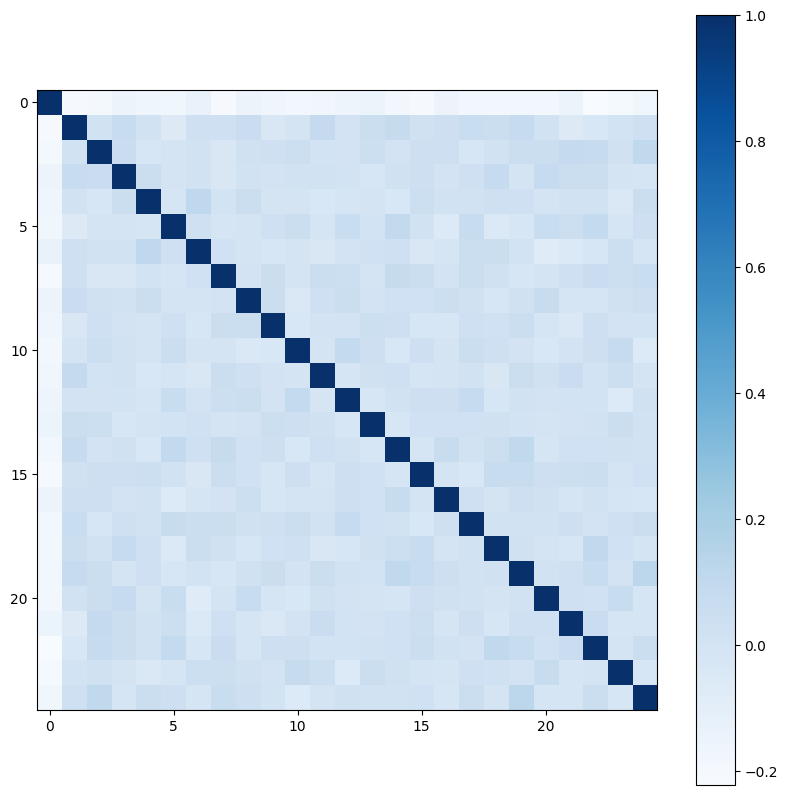

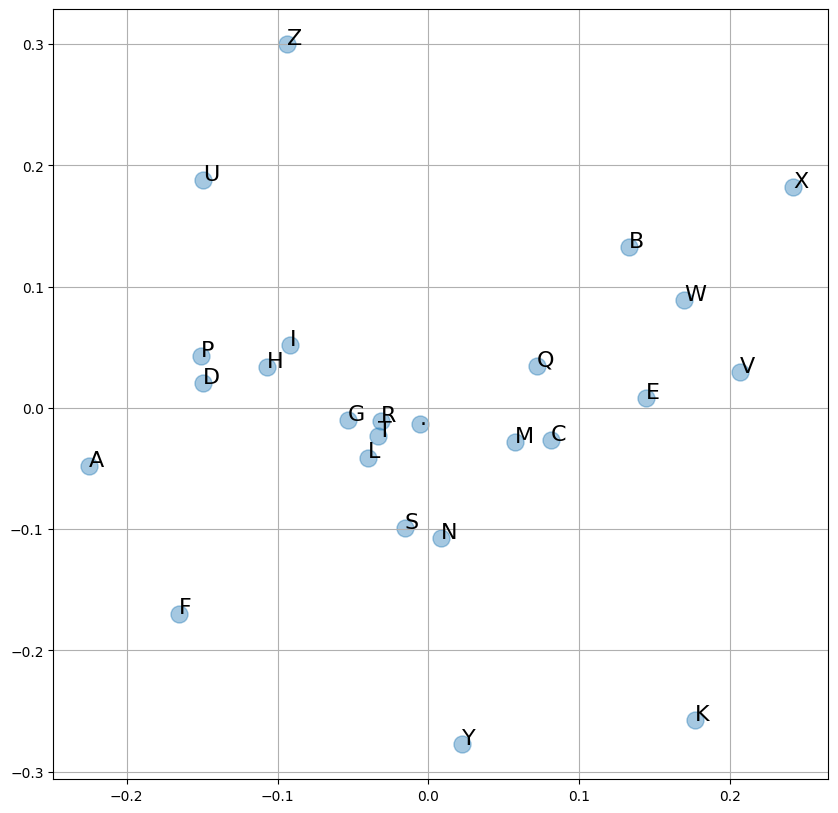

In [61]:
weight = model.distilbert.embeddings.word_embeddings.weight.cpu().detach().numpy()
norm = np.linalg.norm(weight, axis=1)
norm_matrix = norm[:, None] * norm[None, :]
cosin_distance = (weight @ weight.T) / norm_matrix

plt.figure(figsize=(10, 10))
plt.xticks()
plt.imshow(cosin_distance, cmap="Blues")
plt.colorbar()

pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

plt.figure(figsize=(10, 10))
plt.scatter(vis[:, 0], vis[:, 1], s=150, alpha=0.4)
plt.grid(True)
for ix, char in itos.items():
    plt.annotate(char, vis[ix], fontsize=16)

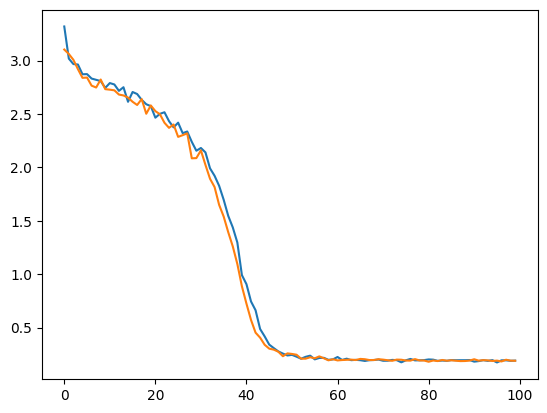

In [62]:
plt.plot(losses)
plt.plot(test_losses)

Briefly discuss your model’s performance – e.g., reasonable baselines, how you could improve things. Comment on what things one would need to consider when training a larger scale, more general version of this model.

We see the loss definitely goes down over time, though the results in the visualization of PCA are unfortunate. The anticipated spatial correlations that we see in the assignment post are not present, and trends we expect to see do not hold. In addition, we see that the training loss and test loss are pretty equal, showing there is likely a bit of overfitting, or that our training data is not substantially different to our test data. 

When training a more general version of this model, it would be important to make sure that context sequences seen in training are not seen quite the same in testing to avoid this equivalent loss issue. We would also likely want to include a much larger context for the protein sequences, since a single protein sequence could be a LOT longer than what we used here and the function of the protein might be changed a lot more without taking into account amino acids a lot further down the line.